In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import pandas as pd
import scipy

In [2]:
import sklearn.metrics
import mir_eval

In [3]:
import cPickle as pickle

In [5]:
from glob import glob
import re

In [6]:
np.set_printoptions(precision=3)
seaborn.set(style='darkgrid')

In [7]:
def plot_curve(file='', intervals=None, labels=None, scores=None, norm=None, **kwargs):
    
    file_name = file
    
    label_agreement = np.zeros((len(labels), len(labels)), dtype=bool)
    
    for i in range(len(labels)):
        for j in range(i, len(labels)):
            label_agreement[i, j] = (labels[i] == labels[j])
            label_agreement[j, i] = label_agreement[i, j]
    
    time_norm = 1
    
    durations = np.diff(intervals, axis=1).ravel()
    
    if norm == 'min':
        time_norm = np.minimum.outer(durations, durations)
        
    elif norm == 'max':
        time_norm = np.maximum.outer(durations, durations)
        
    elif norm == 'hmean':
        time_norm = 2./np.add.outer(durations, durations)
        time_norm *= np.multiply.outer(durations, durations)
    
    # TODO: have the label agreement index out nan-valued scores
    
    scores = scores / time_norm
    
    label_agreement[np.tril_indices_from(label_agreement, k=0)] = False
    
    label_agreement[~np.isfinite(scores)] = False
    
    label_disagreement = ~label_agreement
    
    label_disagreement[np.tril_indices_from(label_disagreement, k=0)] = False
    
    label_disagreement[~np.isfinite(scores)] = False
    
    tp_scores = scores[label_agreement]
    fp_scores = scores[label_disagreement]
    
    num_pos = np.sum(label_agreement)
    num_neg = np.sum(label_disagreement)
    
    y_true = np.concatenate([np.zeros(len(tp_scores)), np.ones(len(fp_scores))])
    y_score = np.concatenate([tp_scores, fp_scores])
    
    fpr, tpr, thr = sklearn.metrics.roc_curve(y_true, y_score)
    
    tp = num_pos * tpr
    fp = num_neg * fpr
    
    precision = tp / (tp + fp)
    recall = tpr
    
    fmeasure = np.asarray([mir_eval.util.f_measure(p, r) for p, r in zip(precision, recall)])
    
    k = np.argmax(fmeasure)
    thr_opt = thr[k]
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.5)
    
    plt.plot(fpr, tpr)
    plt.plot(fpr[k], tpr[k], color='r', marker='*', markersize=10, alpha=0.5)
   
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(file_name)
    
    plt.subplot(1,3,2)
    plt.plot(recall, precision)
    plt.plot(recall[k], precision[k], marker='*', markersize=10, alpha=0.5, color='r')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('norm={}'.format(norm))
   
    plt.subplot(1,3,3)
    plt.plot(thr, fmeasure)
    k = np.argmax(fmeasure)
    plt.plot(thr[k], fmeasure[k], marker='*', markersize=10, alpha=0.5, color='r')
   
    plt.xlabel(r'$\theta$')
    plt.ylabel('$F_1$')
    plt.title(r'({:.3f}, {:.3f})'.format(thr[k], fmeasure[k]))
    plt.tight_layout()
    
    return thr[k], fmeasure[k]

In [8]:
def summarize_results(files):
    
    data = {}
    
    for fname in files:
        results = pickle.load(open(fname, 'r'))
        
        fscores = pd.DataFrame.from_dict([f['fmeasures'] for f in results['file_scores']
                                          if f['fmeasures'] is not None])
        
        match = re.match('.*scores_datasetE(?P<dataset>.*?)E(?P<scale>.*?)_distE(?P<metric>.*).pk', fname)

        fscores['dataset'] = pd.Series(match.group('dataset'), index=fscores.index)
        fscores['scale'] = pd.Series(match.group('scale'), index=fscores.index)
        fscores['metric'] = pd.Series(match.group('metric'), index=fscores.index)
        
        data[fname] = fscores
        
    return data

In [9]:
output = summarize_results(sorted(glob('../data/*.pk')))

In [10]:
all_results = pd.concat(output.values())

In [11]:
all_results.groupby(['scale', 'metric']).describe(percentiles=[])

hmean         max         min        none
scale       metric                                                           
function    L1          count  289.000000  283.000000  292.000000  292.000000
                        mean     0.771748    0.779493    0.773683    0.927197
                        std      0.171378    0.191807    0.168297    0.130891
                        min      0.184176    0.157895    0.188875    0.192771
                        50%      0.775758    0.807692    0.775758    0.989360
                        max      1.000000    1.000000    1.000000    1.000000
            L2          count  289.000000  281.000000  292.000000  292.000000
                        mean     0.738235    0.724356    0.746976    0.924481
                        std      0.172981    0.190521    0.172641    0.131951
                        min      0.179454    0.157895    0.188875    0.192771
                        50%      0.735849    0.749540    0.745286    0.988165
                        max      1.000000    1.000000    1.000000    1.000000
            correlation count  289.000000  238.000000  289.000000  290.000000
                        mean     0.791821    0.774822    0.813201    0.868196
                        std      0.220373    0.225161    0.204180    0.173007
                        min      0.108108    0.055556    0.214286    0.214286
                        50%      0.857143    0.833838    0.882883    0.964686
                        max      1.000000    1.000000    1.000000    1.000000
large_scale L1          count  664.000000  616.000000  671.000000  673.000000
                        mean     0.723527    0.694128    0.728524    0.762132
                        std      0.200909    0.199591    0.195583    0.175398
                        min      0.115618    0.137931    0.243902    0.261170
                        50%      0.727861    0.684927    0.739726    0.767463
                        max      1.000000    1.000000    1.000000    1.000000
            L2          count  663.000000  615.000000  672.000000  673.000000
                        mean     0.725532    0.689794    0.727905    0.763354
                        std      0.199853    0.206012    0.195753    0.174845
                        min      0.214286    0.137931    0.243902    0.260946
                        50%      0.728448    0.680412    0.736424    0.767677
                        max      1.000000    1.000000    1.000000    1.000000
            correlation count  626.000000  590.000000  635.000000  639.000000
                        mean     0.740710    0.713155    0.744599    0.787802
                        std      0.205743    0.211791    0.201327    0.182495
                        min      0.137931    0.085106    0.200000    0.249364
                        50%      0.745019    0.727126    0.750000    0.800000
                        max      1.000000    1.000000    1.000000    1.000000
small_scale L1          count  691.000000  679.000000  689.000000  691.000000
                        mean     0.595778    0.580540    0.597415    0.604588
                        std      0.203833    0.200515    0.204193    0.206080
                        min      0.112175    0.113698    0.114754    0.123457
                        50%      0.582713    0.571960    0.588235    0.595639
                        max      1.000000    1.000000    1.000000    1.000000
            L2          count  688.000000  677.000000  688.000000  692.000000
                        mean     0.597492    0.581304    0.598830    0.605429
                        std      0.204419    0.201200    0.205629    0.205737
                        min      0.115216    0.107600    0.117326    0.123226
                        50%      0.582828    0.566049    0.588583    0.591530
                        max      1.000000    1.000000    1.000000    1.000000
            correlation count  668.000000  652.000000  664.000000  665.000000
                        mean     0.639891    0.618742    0

---

In [157]:
vars().update(pickle.load(open('../data/scores_datasetESALAMI_levelEsmall_scale_distEcorrelation.pk', 'r')))

In [158]:
fscores = pd.DataFrame.from_dict([f['fmeasures'] for f in file_scores if f['fmeasures'] is not None])

In [159]:
fscores.describe()

,hmean,max,min,none
count,668.000000,652.000000,664.000000,665.000000
mean,0.639891,0.618742,0.635829,0.649848
std,0.212408,0.211683,0.211005,0.210843
min,0.108976,0.096000,0.108504,0.113523
25%,0.482742,0.460687,0.473931,0.501947
50%,0.645008,0.614237,0.640392,0.652326
75%,0.805593,0.777865,0.792921,0.811111
max,1.000000,1.000000,1.000000,1.000000


In [128]:
file_scores[k]

{'file_name': 'SALAMI_1224.mp3',
 'fmeasures': {'hmean': 0.41361368713071833,
  'max': 0.3965994826952528,
  'min': 0.41310613633673954,
  'none': 0.41544330581162825},
 'intervals': array([[  0.000e+00,   4.500e-02],
        [  4.500e-02,   9.149e+00],
        [  9.149e+00,   1.267e+01],
        [  1.267e+01,   1.584e+01],
        [  1.584e+01,   1.946e+01],
        [  1.946e+01,   2.284e+01],
        [  2.284e+01,   2.621e+01],
        [  2.621e+01,   2.959e+01],
        [  2.959e+01,   3.306e+01],
        [  3.306e+01,   3.646e+01],
        [  3.646e+01,   3.996e+01],
        [  3.996e+01,   4.339e+01],
        [  4.339e+01,   4.689e+01],
        [  4.689e+01,   5.035e+01],
        [  5.035e+01,   5.387e+01],
        [  5.387e+01,   5.741e+01],
        [  5.741e+01,   6.097e+01],
        [  6.097e+01,   6.452e+01],
        [  6.452e+01,   6.804e+01],
        [  6.804e+01,   7.158e+01],
        [  7.158e+01,   7.514e+01],
        [  7.514e+01,   7.857e+01],
        [  7.857e+01,   8.

(300.18701, 0.41544330581162825)
(84.185944697235072, 0.41310613633673954)
(83.258061773943936, 0.3965994826952528)
(83.975782277805692, 0.41361368713071833)


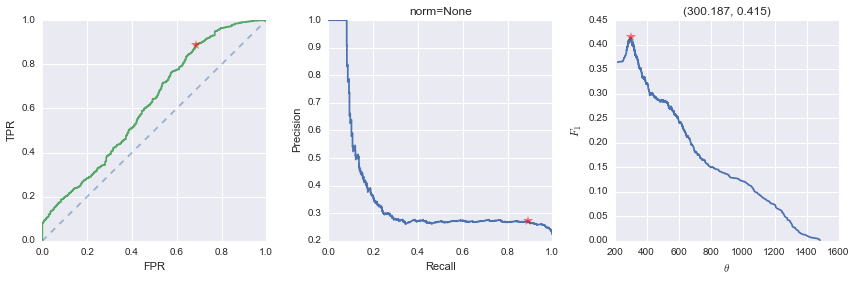

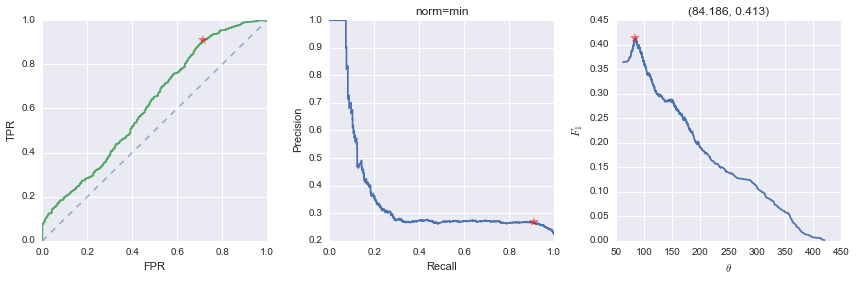

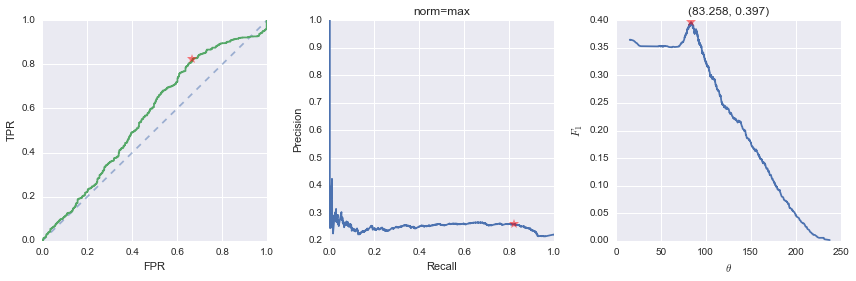

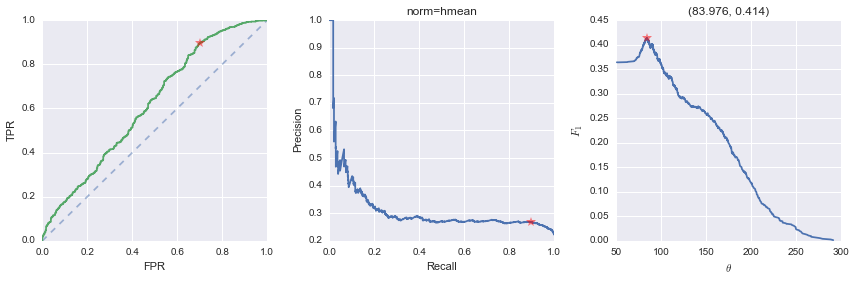

In [129]:
k = 351
for norm in [None, 'min', 'max', 'hmean']:
    print plot_curve(norm=norm, **file_scores[k])

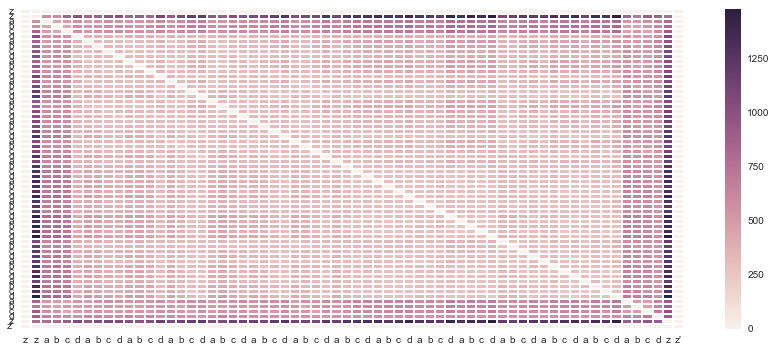

In [127]:
plt.figure(figsize=(12,5))
seaborn.heatmap(file_scores[k]['scores'],
                yticklabels=file_scores[k]['labels'],
                xticklabels=file_scores[k]['labels'])
plt.tight_layout()